In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler


#Метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
#Изменим настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

SEED = 692281488

## Анализ датасета

In [11]:
df_train_orig = pd.read_csv('data/train_dataset.csv',  parse_dates=[0])
df_test_orig = pd.read_csv('data/test_dataset.csv',  parse_dates=[0])

In [12]:
#Функция для возврата часа в дату
def date_plus_hours_to_index(data):
    data = data.copy()
    data['date'] = data['date'] + pd.to_timedelta(data['time'] , 'H')
    data = data.set_index('date')
    return data

In [13]:
df_train_orig = date_plus_hours_to_index(df_train_orig)
df_test_orig = date_plus_hours_to_index(df_test_orig)

In [14]:
print(f'Значения индекса монотонны: {df_train_orig.index.is_monotonic}')
df_train_orig

Значения индекса монотонны: True


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,19,552.96,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


In [15]:
print(f'Значения индекса монотонны: {df_test_orig.index.is_monotonic}')
df_test_orig 

Значения индекса монотонны: True


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


### Первичный анализ

In [16]:
#список признаков, по которым функция анализа не будет строить гистограммы
exception_list = ['weather_pred', 'weather_fact', 'time']

##### [Funct] Функция для первичного анализа

In [17]:
def data_analyse(data, exception_list = []):
    list_c = data.columns.unique()
    temp = data.copy()
    print(temp.info())
    print('-'* 25)
    if temp.duplicated().sum() == 0:
        print(f'Явных дубликатов нет')
    else:
        print(f'Количество явных дубликатов в датасете:{temp.duplicated().sum()}')
    for col_l in list_c:
        uniq_count = temp[col_l].nunique()
        print('-'* 25)
        print(f'{col_l}')
        print('Уникальные значения')
        print(f'Первые 5 значений: {temp[col_l].sort_values().head(5).unique()}')
        print(f'Последние 5 значений: {temp[col_l].sort_values(ascending = False).head(5).unique()}')
        print(f'Количество уникальных значений: {uniq_count},        процент уникальных значений: {round(uniq_count/len(temp)*100, 2)}%')
        print(f'Количество нулевых значений: {temp[(temp[col_l] == 0) | (temp[col_l] == 0.0)][col_l].count()},        процент нулевых значений: {round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2)}%')
        print(f'Количество пропущенных значений: {temp[col_l].isna().sum()},        процент пропущенных значений:{round(temp[col_l].isna().sum()/len(temp)*100, 2)}%')
        if col_l not in exception_list:
            data[col_l].hist(bins = 100)
            plt.title(col_l)
            plt.show()
    try:
        plt.figure(figsize=(8,8), dpi= 80)
        sns.heatmap(data.corr(),  cmap='Purples', center=0, annot=True)
        plt.title('Зависимость признаков')
        plt.show()
    except:
        print('Коррелирующих признаков нет')
    display(data)
    display(data.describe().round(3))  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          37224 non-null  int64  
 1   target        37224 non-null  float64
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB
None
-------------------------
Явных дубликатов нет
-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.06%
Количество нулевых значений: 1551,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
target
Уникальные значения
Первые 5 значени

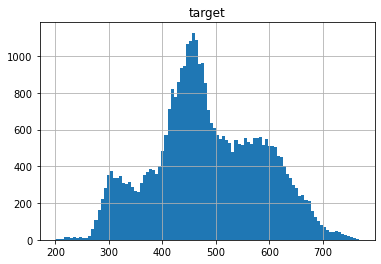

-------------------------
temp
Уникальные значения
Первые 5 значений: [-21.7 -20.9]
Последние 5 значений: [32.5 32.2]
Количество уникальных значений: 474,        процент уникальных значений: 1.27%
Количество нулевых значений: 171,        процент нулевых значений: 0.46%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


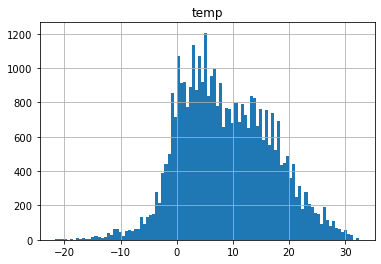

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-20. -19.]
Последние 5 значений: [33. 32.]
Количество уникальных значений: 54,        процент уникальных значений: 0.15%
Количество нулевых значений: 1506,        процент нулевых значений: 4.05%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%


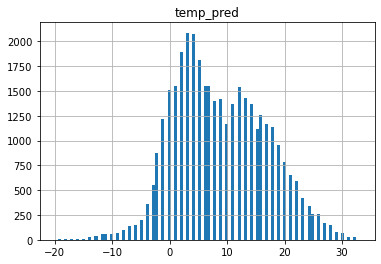

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: [' п/обл, 35% дождь']
Последние 5 значений: ['ясно,ветер']
Количество уникальных значений: 2181,        процент уникальных значений: 5.86%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: [' обл, ветер']
Последние 5 значений: ['ясно,ветерок']
Количество уникальных значений: 580,        процент уникальных значений: 1.56%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 1,        процент пропущенных значений:0.0%


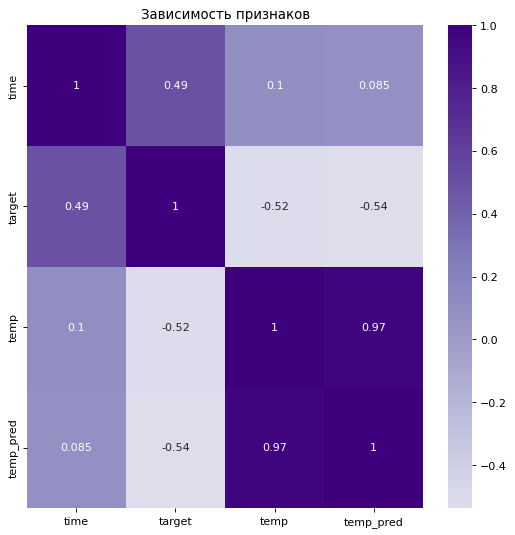

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,19,552.96,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


,time,target,temp,temp_pred
count,37224.0,37224.0,37224.0,37136.0
mean,11.5,483.731,8.749,8.769
std,6.922,101.459,8.126,8.018
min,0.0,198.982,-21.7,-20.0
25%,5.75,418.951,2.6,3.0
50%,11.5,473.064,7.9,8.0
75%,17.25,561.217,14.7,15.0
max,23.0,767.888,32.5,33.0


In [18]:
data_analyse(df_train_orig, exception_list)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2928 non-null   int64  
 1   target        2928 non-null   float64
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB
None
-------------------------
Явных дубликатов нет
-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.82%
Количество нулевых значений: 122,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
target
Уникальные значения
Первые 5 значени

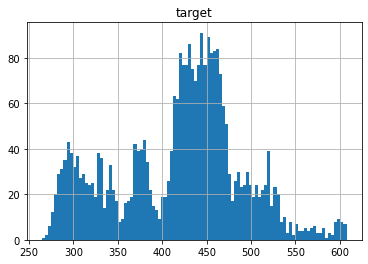

-------------------------
temp
Уникальные значения
Первые 5 значений: [-3.1 -2.9]
Последние 5 значений: [31.7 30.6]
Количество уникальных значений: 270,        процент уникальных значений: 9.22%
Количество нулевых значений: 3,        процент нулевых значений: 0.1%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


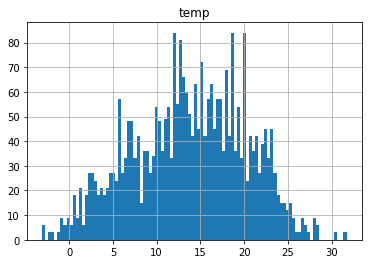

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-3.]
Последние 5 значений: [29.]
Количество уникальных значений: 32,        процент уникальных значений: 1.09%
Количество нулевых значений: 54,        процент нулевых значений: 1.84%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%


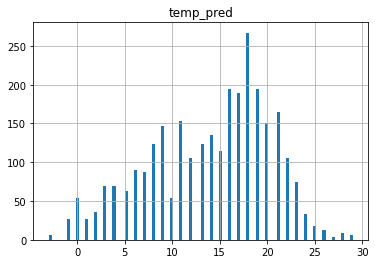

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: ['0']
Последние 5 значений: ['ясно, юго-зап.ветер' 'ясно, штиль']
Количество уникальных значений: 246,        процент уникальных значений: 8.4%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: ['дождь']
Последние 5 значений: ['ясно, хол.ветерок']
Количество уникальных значений: 121,        процент уникальных значений: 4.13%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


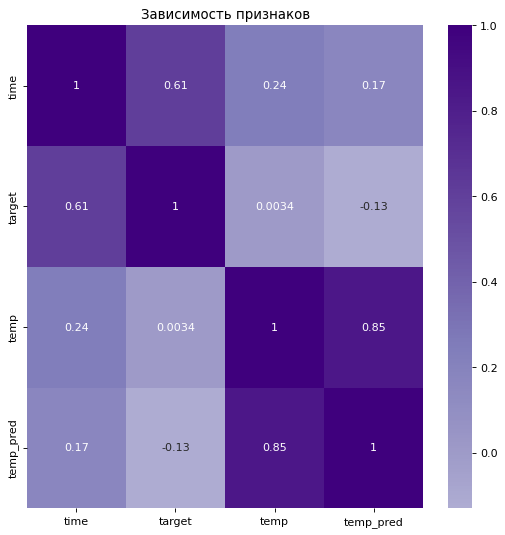

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


,time,target,temp,temp_pred
count,2928.0,2928.0,2928.0,2904.0
mean,11.5,419.467,13.769,13.91
std,6.923,71.393,6.48,6.382
min,0.0,264.819,-3.1,-3.0
25%,5.75,371.384,9.2,9.0
50%,11.5,431.477,14.0,15.0
75%,17.25,462.414,18.7,19.0
max,23.0,607.474,31.7,29.0


In [19]:
data_analyse(df_test_orig, exception_list)

In [20]:
#Посмотрим на динамику среднего значения и среднеквадратичного отклонения в разрезе 30 и 160 дней
def data_std_mean(data, count_rollin):
    data_copy = data.copy()
    data_copy.sort_index(inplace=True)
    data_copy = data_copy.resample('1D').sum() 
    data_copy['mean'] = data_copy['target'].rolling(count_rollin).mean()
    data_copy['std'] = data_copy['target'].rolling(count_rollin).std()
    
    plt.figure(figsize=(20, 6))
    plt.subplot(312)
    data_copy[['target', 'mean', 'std']].plot(ax=plt.gca())
    plt.show()


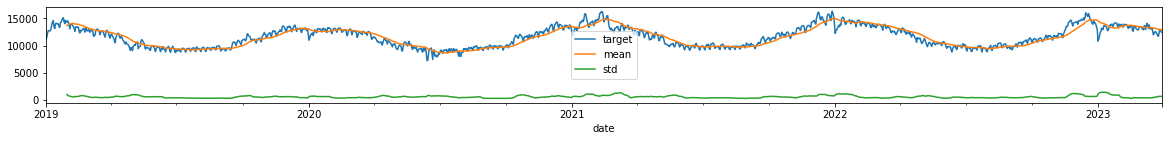

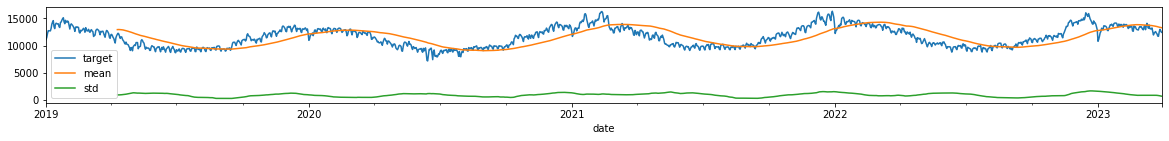

In [21]:
data_std_mean(df_train_orig, 30)
data_std_mean(df_train_orig, 100)

#### Тест Дики-Фуллера на стационарность

In [22]:
ts = df_train_orig['target']
st_test = adfuller(ts, regression = 'ctt')
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.572234
p-value: 0.005070
Critical Values:
	1%: -4.371
	5%: -3.833
	10%: -3.553


Исходя из полученных результатов, мы можем сделать вывод, что данные являются стационарными. Это означает, что они не имеют тренда или сезонности, и статистические характеристики данных могут быть считаны как постоянные с течением времени. p.s. Но это просто для полноты картины

<b>Сезонность и Тренд

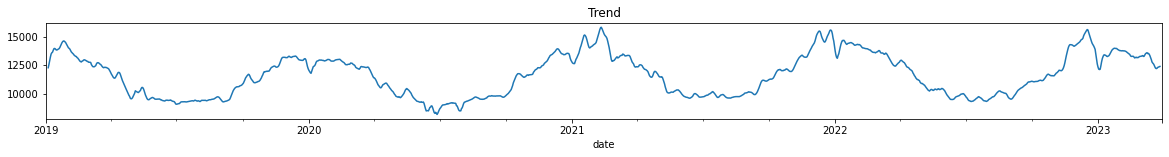

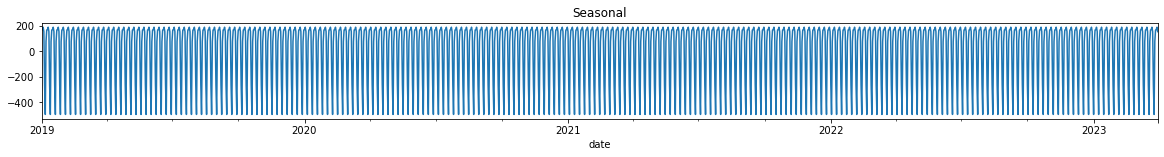

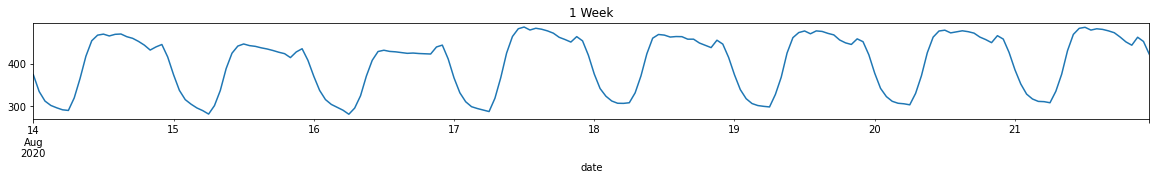

In [23]:
df = df_train_orig['target'].resample('1D').sum() 
decomposed = seasonal_decompose(df) 
# Тренд
plt.figure(figsize=(20, 6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()
#Сезонность
plt.figure(figsize=(20, 6))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.show()
#1 Неделя
plt.figure(figsize=(20, 6))
plt.subplot(313)
df_train_orig.loc['2020-08-14':'2020-08-21', 'target'].plot(ax=plt.gca())
plt.title('1 Week')
plt.show()